# 📊 SmartPortfolio AI - Data Collection

## Notebook 01: S&P 500 Data Collection

**Purpose:** Collect historical price data for S&P 500 stocks and store in SQL Server database

**Data Sources:**
- S&P 500 tickers from Wikipedia
- Historical price data from Yahoo Finance
- Company fundamentals from yfinance

**Database Tables Populated:**
- `market.sp500_tickers` - Company information
- `market.daily_prices` - Historical OHLCV data
- `market.dividends` - Dividend history
- `market.splits` - Stock split history

**Last Updated:** 2024-10-02

In [1]:
# Standard library imports
import sys
from pathlib import Path
import os
from datetime import datetime, timedelta
import time
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Web scraping
import requests
from bs4 import BeautifulSoup

# Financial data
import yfinance as yf

# Database
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Progress tracking
from tqdm.notebook import tqdm

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Load environment variables
load_dotenv(project_root / '.env')

# Import custom modules
from utils.database_connector import DatabaseConnector

print("✅ All libraries imported successfully!")
print(f"📁 Project root: {project_root}")

✅ All libraries imported successfully!
📁 Project root: /Users/RiyanshiKedia/Documents/GitHub/smartportfolio/SmartPortfolio


In [2]:
# Configuration settings
CONFIG = {
    'START_DATE': (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d'),  # 1 year of data
    'END_DATE': datetime.now().strftime('%Y-%m-%d'),
    'BATCH_SIZE': 20,  # Fetch 20 stocks at a time
    'REQUEST_DELAY': 1,  # Delay between batches (seconds)
    'MAX_RETRIES': 3,
    'MIN_VOLUME': 100000,  # Minimum daily volume threshold
}

print("📊 Configuration:")
print(f"   Start Date: {CONFIG['START_DATE']}")
print(f"   End Date: {CONFIG['END_DATE']}")
print(f"   Batch Size: {CONFIG['BATCH_SIZE']} stocks")
print(f"   Request Delay: {CONFIG['REQUEST_DELAY']} seconds")

📊 Configuration:
   Start Date: 2024-10-02
   End Date: 2025-10-02
   Batch Size: 20 stocks
   Request Delay: 1 seconds


In [3]:
# Initialize database connection
db = DatabaseConnector()

# Test connection
if db.test_connection():
    print("✅ Database connection successful!")
else:
    print("❌ Database connection failed!")
    raise Exception("Cannot proceed without database connection")

2025-10-02 20:02:26,535 - INFO - Attempting connection with pymssql...
2025-10-02 20:02:26,595 - INFO - ✅ Database connection established
2025-10-02 20:02:26,653 - INFO - ✅ Database connection test passed


✅ Database connection successful!


---

## 📋 Section 1: S&P 500 Ticker Collection

We'll scrape the S&P 500 ticker list from Wikipedia and get company information.

In [4]:
def get_sp500_tickers():
    """
    Fetch S&P 500 tickers from Wikipedia
    Returns: DataFrame with ticker, company_name, sector, industry
    """
    print("🔄 Fetching S&P 500 tickers from Wikipedia...")
    
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    
    # Add headers to avoid being blocked
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    try:
        # Fetch the page with headers
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        
        # Parse HTML
        soup = BeautifulSoup(response.content, 'html.parser')
        table = soup.find('table', {'id': 'constituents'})
        
        if not table:
            raise Exception("Could not find S&P 500 constituents table")
        
        # Extract data
        tickers_data = []
        rows = table.find_all('tr')[1:]  # Skip header
        
        for row in rows:
            cols = row.find_all('td')
            if len(cols) >= 4:
                ticker = cols[0].text.strip().replace('.', '-')  # Fix ticker format
                company_name = cols[1].text.strip()
                sector = cols[2].text.strip()
                industry = cols[3].text.strip()
                
                tickers_data.append({
                    'ticker': ticker,
                    'company_name': company_name,
                    'sector': sector,
                    'industry': industry,
                    'added_date': datetime.now().date(),
                    'is_active': True
                })
        
        df = pd.DataFrame(tickers_data)
        print(f"✅ Successfully fetched {len(df)} S&P 500 tickers")
        return df
        
    except requests.exceptions.HTTPError as e:
        print(f"❌ HTTP Error: {e}")
        print("⚠️  Wikipedia may be blocking requests. Using pandas read_html as fallback...")
        
        # Fallback method using pandas
        try:
            tables = pd.read_html(url)
            df = tables[0]  # First table is usually the S&P 500 list
            
            # Clean up column names
            df = df.rename(columns={
                'Symbol': 'ticker',
                'Security': 'company_name',
                'GICS Sector': 'sector',
                'GICS Sub-Industry': 'industry'
            })
            
            # Fix ticker format
            df['ticker'] = df['ticker'].str.replace('.', '-', regex=False)
            df['added_date'] = datetime.now().date()
            df['is_active'] = True
            
            # Select only needed columns
            df = df[['ticker', 'company_name', 'sector', 'industry', 'added_date', 'is_active']]
            
            print(f"✅ Successfully fetched {len(df)} S&P 500 tickers using fallback method")
            return df
            
        except Exception as fallback_error:
            print(f"❌ Fallback method also failed: {fallback_error}")
            return pd.DataFrame()
        
    except Exception as e:
        print(f"❌ Error fetching S&P 500 tickers: {e}")
        return pd.DataFrame()

# Fetch tickers
sp500_df = get_sp500_tickers()

# Display first 10
if not sp500_df.empty:
    print("\n📊 First 10 S&P 500 companies:")
    display(sp500_df.head(10))
else:
    print("❌ Failed to fetch tickers. Please check your internet connection.")

🔄 Fetching S&P 500 tickers from Wikipedia...
✅ Successfully fetched 503 S&P 500 tickers

📊 First 10 S&P 500 companies:


,ticker,company_name,sector,industry,added_date,is_active
0,MMM,3M,Industrials,Industrial Conglomerates,2025-10-02,True
1,AOS,A. O. Smith,Industrials,Building Products,2025-10-02,True
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,2025-10-02,True
3,ABBV,AbbVie,Health Care,Biotechnology,2025-10-02,True
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,2025-10-02,True
5,ADBE,Adobe Inc.,Information Technology,Application Software,2025-10-02,True
6,AMD,Advanced Micro Devices,Information Technology,Semiconductors,2025-10-02,True
7,AES,AES Corporation,Utilities,Independent Power Producers & Energy Traders,2025-10-02,True
8,AFL,Aflac,Financials,Life & Health Insurance,2025-10-02,True
9,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,2025-10-02,True


📊 Sector Distribution:
sector
Industrials               79
Financials                75
Information Technology    68
Health Care               60
Consumer Discretionary    50
Consumer Staples          37
Utilities                 31
Real Estate               31
Materials                 26
Communication Services    24
Energy                    22
Name: count, dtype: int64


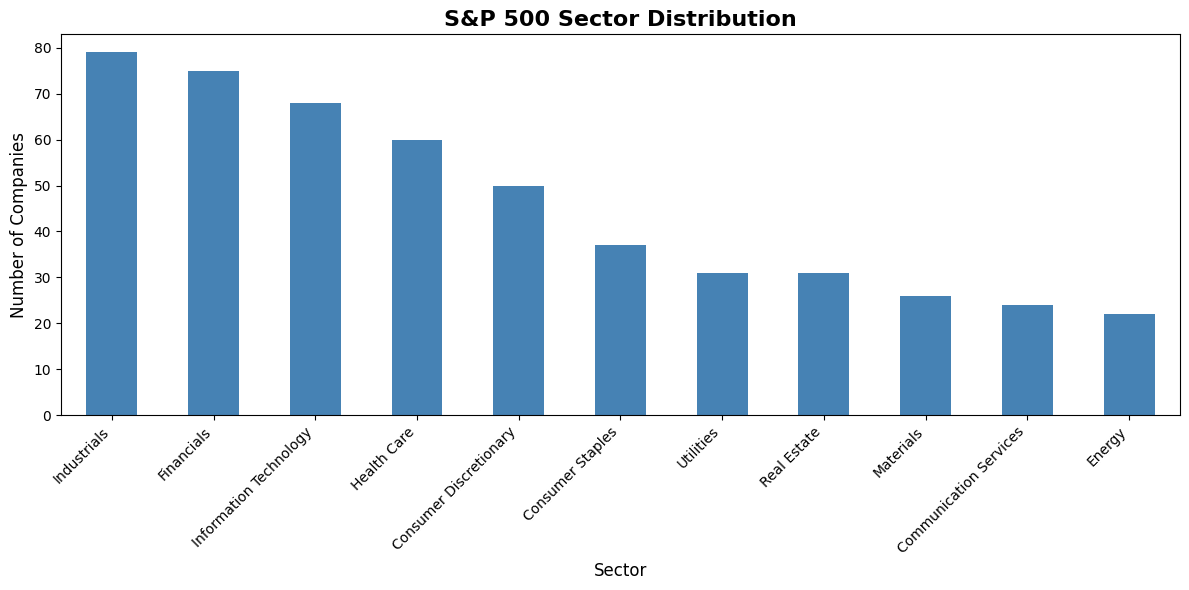

In [5]:
# Analyze sector distribution
if not sp500_df.empty:
    sector_counts = sp500_df['sector'].value_counts()
    
    print("📊 Sector Distribution:")
    print(sector_counts)
    
    # Visualize
    plt.figure(figsize=(12, 6))
    sector_counts.plot(kind='bar', color='steelblue')
    plt.title('S&P 500 Sector Distribution', fontsize=16, fontweight='bold')
    plt.xlabel('Sector', fontsize=12)
    plt.ylabel('Number of Companies', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [6]:
# Store S&P 500 tickers in database
if not sp500_df.empty:
    try:
        # Check if table has data
        existing_count = db.get_row_count('sp500_tickers', schema='market')
        
        if existing_count > 0:
            print(f"⚠️  Table already has {existing_count} records")
            print("   Clearing existing data before inserting...")
            
            # Clear existing data (DELETE is safer than DROP with foreign keys)
            with db.engine.begin() as conn:
                conn.execute(text("DELETE FROM market.sp500_tickers"))
            print("   ✅ Existing data cleared")
        
        # Insert new data
        success = db.insert_data(
            sp500_df, 
            table_name='sp500_tickers', 
            schema='market',
            if_exists='append'  # Use append instead of replace
        )
        
        if success:
            print(f"✅ Successfully stored {len(sp500_df)} tickers in database")
            
            # Verify
            count = db.get_row_count('sp500_tickers', schema='market')
            print(f"📊 Verification: {count} records in market.sp500_tickers")
        else:
            print("❌ Failed to store tickers in database")
            
    except Exception as e:
        print(f"❌ Error storing tickers: {e}")
else:
    print("❌ No tickers to store")

2025-10-02 20:02:31,829 - INFO - ✅ Inserted 503 records into market.sp500_tickers


⚠️  Table already has 503 records
   Clearing existing data before inserting...
   ✅ Existing data cleared
✅ Successfully stored 503 tickers in database
📊 Verification: 503 records in market.sp500_tickers


---

## 📈 Section 2: Historical Price Data Collection

Fetch historical OHLCV (Open, High, Low, Close, Volume) data for all S&P 500 stocks.

**Strategy:**
- Process stocks in batches to avoid rate limiting
- Add delay between batches
- Implement retry logic for failed downloads
- Validate and clean data before storage

In [7]:
def fetch_stock_data(tickers, start_date, end_date):
    """
    Fetch historical price data for a list of tickers
    """
    if not tickers:
        return pd.DataFrame()
    
    try:
        # Download data using yfinance
        data = yf.download(
            tickers, 
            start=start_date, 
            end=end_date,
            progress=False,
            group_by='ticker' if len(tickers) > 1 else None
        )
        
        if data.empty:
            return pd.DataFrame()
        
        # Reshape data for database storage
        if len(tickers) == 1:
            # Single ticker
            df = data.reset_index()
            df['ticker'] = tickers[0]
        else:
            # Multiple tickers
            dfs = []
            for ticker in tickers:
                if ticker in data.columns.get_level_values(0):
                    ticker_data = data[ticker].copy()
                    ticker_data = ticker_data.reset_index()
                    ticker_data['ticker'] = ticker
                    dfs.append(ticker_data)
            
            if dfs:
                df = pd.concat(dfs, ignore_index=True)
            else:
                return pd.DataFrame()
        
        # Rename columns to match database schema
        df = df.rename(columns={
            'Date': 'date',
            'Open': 'open',
            'High': 'high',
            'Low': 'low',
            'Close': 'close',
            'Adj Close': 'adj_close',
            'Volume': 'volume'
        })
        
        # Ensure correct data types
        df['date'] = pd.to_datetime(df['date']).dt.date
        df['volume'] = df['volume'].astype('int64')
        
        # Reorder columns
        df = df[['ticker', 'date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']]
        
        return df
        
    except Exception as e:
        print(f"❌ Error fetching data: {e}")
        return pd.DataFrame()


def validate_price_data(df):
    """
    Validate and clean price data
    """
    if df.empty:
        return df
    
    original_count = len(df)
    
    # Remove rows with missing critical values
    df = df.dropna(subset=['close', 'volume'])
    
    # Remove rows with invalid prices
    df = df[df['close'] > 0]
    df = df[df['volume'] >= 0]
    
    # Remove extreme outliers (optional)
    # df = df[df['close'] < df['close'].quantile(0.99)]
    
    # Sort by ticker and date
    df = df.sort_values(['ticker', 'date']).reset_index(drop=True)
    
    cleaned_count = len(df)
    if cleaned_count < original_count:
        print(f"   Cleaned: {original_count} → {cleaned_count} records ({original_count - cleaned_count} removed)")
    
    return df

In [13]:
# Get list of tickers
tickers = sp500_df['ticker'].tolist()
total_tickers = len(tickers)

print(f"🚀 Starting data collection for {total_tickers} stocks")
print(f"📅 Date range: {CONFIG['START_DATE']} to {CONFIG['END_DATE']}")
print(f"📦 Batch size: {CONFIG['BATCH_SIZE']}")
print("-" * 60)

# Initialize tracking variables
all_data = []
successful_tickers = []
failed_tickers = []

# Process in batches
num_batches = (total_tickers + CONFIG['BATCH_SIZE'] - 1) // CONFIG['BATCH_SIZE']

for i in tqdm(range(0, total_tickers, CONFIG['BATCH_SIZE']), desc="📊 Processing batches"):
    batch_num = (i // CONFIG['BATCH_SIZE']) + 1
    batch_tickers = tickers[i:i + CONFIG['BATCH_SIZE']]
    
    print(f"\n🔄 Batch {batch_num}/{num_batches}: {len(batch_tickers)} tickers")
    print(f"   {', '.join(batch_tickers[:5])}{'...' if len(batch_tickers) > 5 else ''}")
    
    try:
        # Fetch data
        df_batch = fetch_stock_data(batch_tickers, CONFIG['START_DATE'], CONFIG['END_DATE'])
        
        if not df_batch.empty:
            # Validate data
            df_batch = validate_price_data(df_batch)
            
            if not df_batch.empty:
                all_data.append(df_batch)
                successful_tickers.extend(batch_tickers)
                print(f"   ✅ Fetched {len(df_batch)} records")
            else:
                failed_tickers.extend(batch_tickers)
                print(f"   ⚠️  No valid data after cleaning")
        else:
            failed_tickers.extend(batch_tickers)
            print(f"   ❌ No data fetched")
    
    except Exception as e:
        failed_tickers.extend(batch_tickers)
        print(f"   ❌ Error: {e}")
    
    # Delay between batches (except last batch)
    if i + CONFIG['BATCH_SIZE'] < total_tickers:
        time.sleep(CONFIG['REQUEST_DELAY'])

# Combine all data
if all_data:
    final_df = pd.concat(all_data, ignore_index=True)
    print(f"\n✅ Data collection complete!")
    print(f"   Total records: {len(final_df):,}")
    print(f"   Successful tickers: {len(set(successful_tickers))}")
    print(f"   Failed tickers: {len(set(failed_tickers))}")
else:
    final_df = pd.DataFrame()
    print("\n❌ No data collected")

🚀 Starting data collection for 503 stocks
📅 Date range: 2024-10-02 to 2025-10-02
📦 Batch size: 20
------------------------------------------------------------


📊 Processing batches:   0%|          | 0/26 [00:00<?, ?it/s]


🔄 Batch 1/26: 20 tickers
   MMM, AOS, ABT, ABBV, ACN...
   ✅ Fetched 5000 records

🔄 Batch 2/26: 20 tickers
   GOOG, MO, AMZN, AMCR, AEE...
   ✅ Fetched 5000 records

🔄 Batch 3/26: 20 tickers
   APP, APTV, ACGL, ADM, ANET...
   ✅ Fetched 5000 records

🔄 Batch 4/26: 20 tickers
   BRK-B, BBY, TECH, BIIB, BLK...
   ✅ Fetched 5000 records

🔄 Batch 5/26: 20 tickers
   CDNS, CPT, CPB, COF, CAH...
   ✅ Fetched 5000 records

🔄 Batch 6/26: 20 tickers
   CMG, CB, CHD, CI, CINF...
   ✅ Fetched 5000 records

🔄 Batch 7/26: 20 tickers
   STZ, CEG, COO, CPRT, GLW...
   ✅ Fetched 5000 records

🔄 Batch 8/26: 20 tickers
   DECK, DE, DELL, DAL, DVN...
   ✅ Fetched 5000 records

🔄 Batch 9/26: 20 tickers
   ETN, EBAY, ECL, EIX, EW...
   ✅ Fetched 5000 records

🔄 Batch 10/26: 20 tickers
   EVRG, ES, EXC, EXE, EXPE...
   ✅ Fetched 5000 records

🔄 Batch 11/26: 20 tickers
   FTNT, FTV, FOXA, FOX, BEN...
   ✅ Fetched 5000 records

🔄 Batch 12/26: 20 tickers
   GDDY, GS, HAL, HIG, HAS...
   ✅ Fetched 5000 record

In [14]:
# Display sample of collected data
if not final_df.empty:
    print("📊 Sample of collected data:")
    print(final_df.head(10))
    
    print("\n📊 Data Info:")
    print(final_df.info())
    
    print("\n📊 Summary Statistics:")
    print(final_df.describe())
else:
    print("❌ No data to display")

📊 Sample of collected data:
Price ticker        date        open        high         low       close  \
0          A  2024-10-02  145.093099  146.461986  143.942429  145.360916   
1          A  2024-10-03  144.259841  144.805419  142.930627  143.386932   
2          A  2024-10-04  145.023657  145.380761  143.039750  143.803558   
3          A  2024-10-07  142.970298  143.287715  141.680755  142.732224   
4          A  2024-10-08  142.841364  144.071393  142.682648  143.446457   
5          A  2024-10-09  143.863063  144.418555  143.019897  143.634918   
6          A  2024-10-10  142.057727  143.248068  141.452634  141.591507   
7          A  2024-10-11  141.908917  143.892824  141.908917  142.662811   
8          A  2024-10-14  142.841352  143.902750  141.670853  143.089340   
9          A  2024-10-15  143.188542  145.479953  142.910796  143.416687   

Price   volume  
0      1200100  
1      1100000  
2      1001100  
3       836700  
4       915000  
5       634700  
6      1288900  

In [15]:
# Debug: Check what happened during collection
print("=" * 60)
print("🔍 DEBUG INFORMATION")
print("=" * 60)
print(f"all_data list length: {len(all_data)}")
print(f"successful_tickers count: {len(set(successful_tickers))}")
print(f"failed_tickers count: {len(set(failed_tickers))}")

if failed_tickers:
    print(f"\n❌ Failed tickers (first 20): {failed_tickers[:20]}")

if all_data:
    print(f"\n✅ Successfully collected data!")
    print(f"   Number of dataframes: {len(all_data)}")
    print(f"   First dataframe shape: {all_data[0].shape if all_data else 'N/A'}")
    print(f"   First dataframe columns: {list(all_data[0].columns) if all_data else 'N/A'}")
    print(f"\n   Sample from first batch:")
    print(all_data[0].head(3) if all_data else "No data")
else:
    print("\n❌ No data collected in all_data list")

print("=" * 60)

🔍 DEBUG INFORMATION
all_data list length: 26
successful_tickers count: 503
failed_tickers count: 0

✅ Successfully collected data!
   Number of dataframes: 26
   First dataframe shape: (5000, 7)
   First dataframe columns: ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume']

   Sample from first batch:
Price ticker        date        open        high         low       close  \
0          A  2024-10-02  145.093099  146.461986  143.942429  145.360916   
1          A  2024-10-03  144.259841  144.805419  142.930627  143.386932   
2          A  2024-10-04  145.023657  145.380761  143.039750  143.803558   

Price   volume  
0      1200100  
1      1100000  
2      1001100  


In [16]:
# Store price data in database
if not final_df.empty:
    print("💾 Storing data in database...")
    print(f"   Table: market.daily_prices")
    print(f"   Records: {len(final_df):,}")
    
    try:
        success = db.insert_data(
            final_df,
            table_name='daily_prices',
            schema='market',
            if_exists='append'  # Append to existing data
        )
        
        if success:
            print("✅ Data successfully stored in database!")
            
            # Verify insertion
            total_records = db.get_row_count('daily_prices', schema='market')
            print(f"📊 Total records in market.daily_prices: {total_records:,}")
            
            # Get date range
            latest_date = db.get_latest_date('daily_prices', schema='market', date_column='date')
            print(f"📅 Latest date in database: {latest_date}")
        else:
            print("❌ Failed to store data in database")
    
    except Exception as e:
        print(f"❌ Error storing data: {e}")
else:
    print("❌ No data to store")

💾 Storing data in database...
   Table: market.daily_prices
   Records: 125,750


2025-10-02 20:07:53,794 - INFO - ✅ Inserted 125750 records into market.daily_prices


✅ Data successfully stored in database!
📊 Total records in market.daily_prices: 125,750
📅 Latest date in database: 2025-10-01


---

## ✅ Section 3: Data Verification & Quality Checks

Verify that data was stored correctly and check data quality metrics.

In [17]:
# Query database for statistics
print("📊 DATABASE STATISTICS")
print("=" * 60)

try:
    # Total tickers
    query_tickers = "SELECT COUNT(*) as count FROM market.sp500_tickers WHERE is_active = 1"
    result = db.execute_query(query_tickers)
    total_tickers = result['count'].iloc[0]
    print(f"✓ Active tickers: {total_tickers}")
    
    # Total price records
    query_prices = "SELECT COUNT(*) as count FROM market.daily_prices"
    result = db.execute_query(query_prices)
    total_prices = result['count'].iloc[0]
    print(f"✓ Price records: {total_prices:,}")
    
    # Date range
    query_dates = """
        SELECT 
            MIN(date) as earliest_date,
            MAX(date) as latest_date
        FROM market.daily_prices
    """
    result = db.execute_query(query_dates)
    earliest = result['earliest_date'].iloc[0]
    latest = result['latest_date'].iloc[0]
    print(f"✓ Date range: {earliest} to {latest}")
    
    # Tickers with data
    query_tickers_data = "SELECT COUNT(DISTINCT ticker) as count FROM market.daily_prices"
    result = db.execute_query(query_tickers_data)
    tickers_with_data = result['count'].iloc[0]
    print(f"✓ Tickers with data: {tickers_with_data}")
    
    # Data completeness
    completeness = (tickers_with_data / total_tickers * 100) if total_tickers > 0 else 0
    print(f"✓ Data completeness: {completeness:.1f}%")
    
    print("=" * 60)
    
except Exception as e:
    print(f"❌ Error querying database: {e}")

2025-10-02 20:07:59,483 - INFO - ✅ Query executed successfully, returned 1 rows
2025-10-02 20:07:59,498 - INFO - ✅ Query executed successfully, returned 1 rows
2025-10-02 20:07:59,508 - INFO - ✅ Query executed successfully, returned 1 rows


📊 DATABASE STATISTICS
✓ Active tickers: 503
✓ Price records: 125,750
✓ Date range: 2024-10-02 to 2025-10-01


2025-10-02 20:07:59,759 - INFO - ✅ Query executed successfully, returned 1 rows


✓ Tickers with data: 503
✓ Data completeness: 100.0%


In [18]:
# Check for tickers with missing data
try:
    query_missing = """
        SELECT t.ticker, t.company_name, t.sector
        FROM market.sp500_tickers t
        LEFT JOIN market.daily_prices p ON t.ticker = p.ticker
        WHERE t.is_active = 1
        AND p.ticker IS NULL
        ORDER BY t.ticker
    """
    
    missing_df = db.execute_query(query_missing)
    
    if not missing_df.empty:
        print(f"⚠️  {len(missing_df)} tickers with NO price data:")
        print(missing_df)
    else:
        print("✅ All active tickers have price data!")
        
except Exception as e:
    print(f"❌ Error checking missing data: {e}")

2025-10-02 20:08:04,280 - INFO - ✅ Query executed successfully, returned 0 rows


✅ All active tickers have price data!


2025-10-02 20:08:59,614 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:08:59,665 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:08:59,719 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:08:59,839 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:08:59,886 - INFO - ✅ Query executed successfully, returned 250 rows


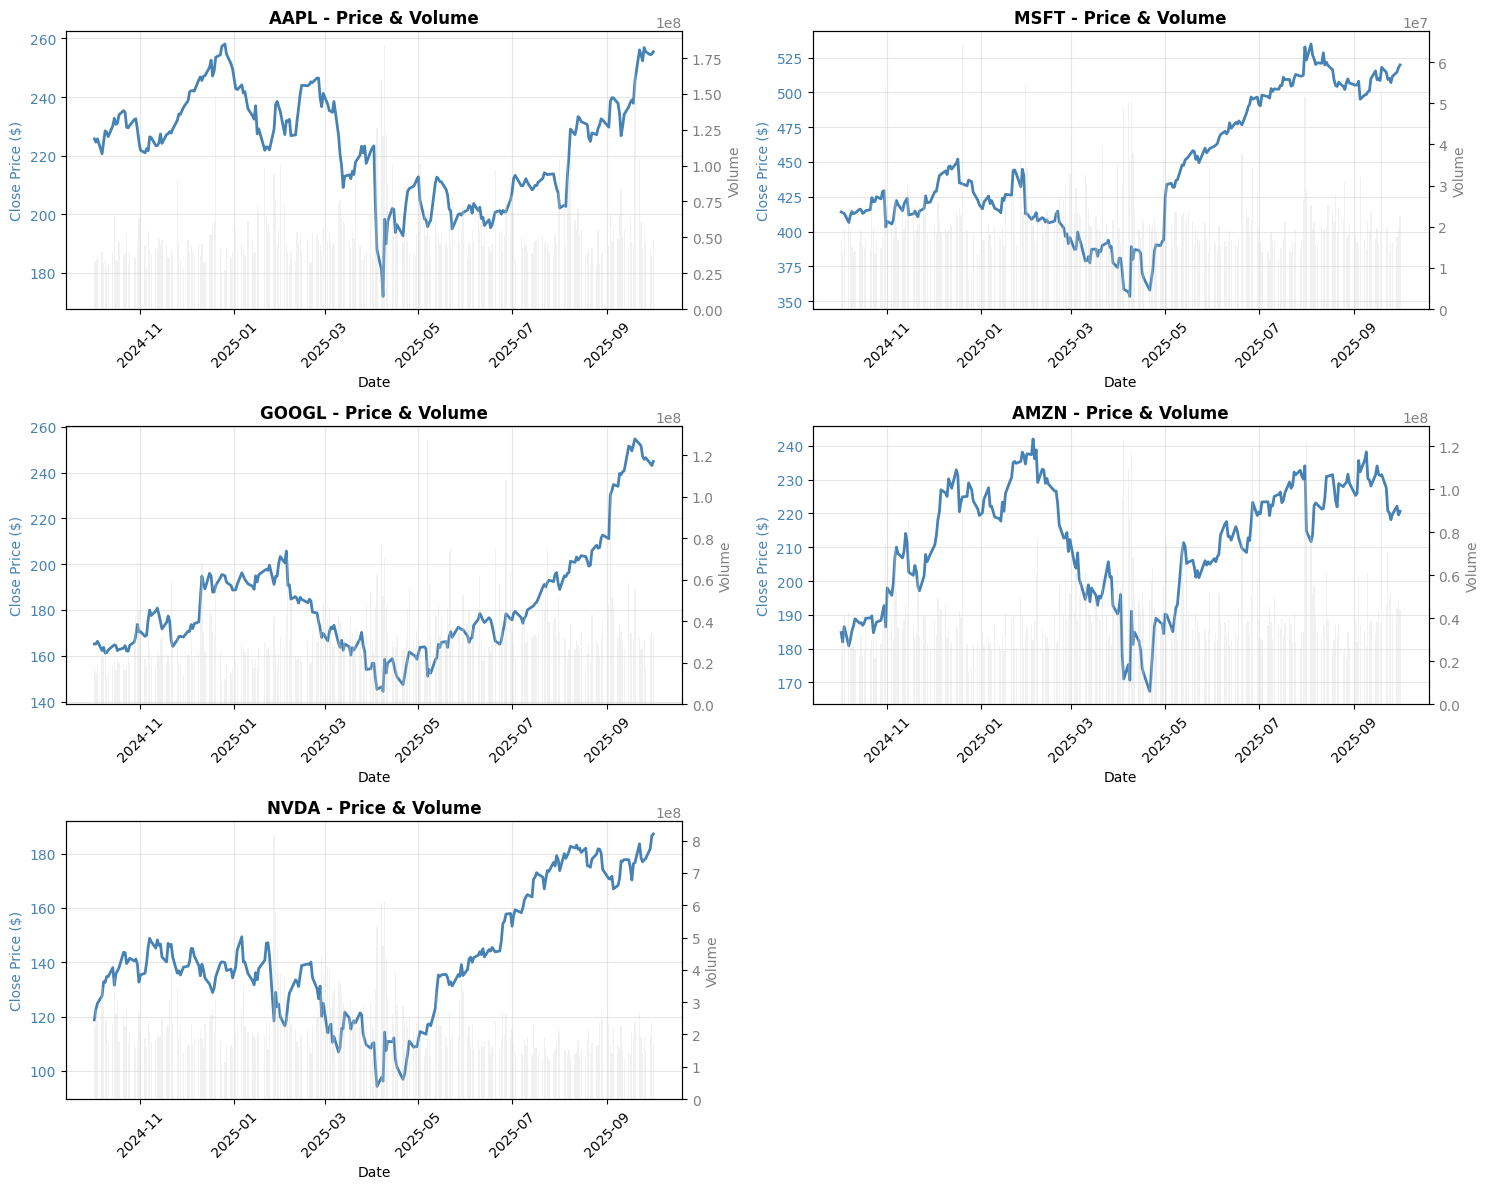

In [21]:
# Plot sample stock prices
try:
    # Get a few popular stocks
    sample_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA']
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for idx, ticker in enumerate(sample_tickers):
        # Use square brackets to escape reserved keywords in SQL Server
        query = f"""
            SELECT date, [close], volume
            FROM market.daily_prices
            WHERE ticker = '{ticker}'
            ORDER BY date
        """
        
        df_ticker = db.execute_query(query)
        
        if not df_ticker.empty:
            ax = axes[idx]
            
            # Price chart
            ax2 = ax.twinx()
            
            ax.plot(df_ticker['date'], df_ticker['close'], color='steelblue', linewidth=2)
            ax2.bar(df_ticker['date'], df_ticker['volume'], color='lightgray', alpha=0.3)
            
            ax.set_title(f'{ticker} - Price & Volume', fontsize=12, fontweight='bold')
            ax.set_xlabel('Date')
            ax.set_ylabel('Close Price ($)', color='steelblue')
            ax2.set_ylabel('Volume', color='gray')
            ax.tick_params(axis='y', labelcolor='steelblue')
            ax2.tick_params(axis='y', labelcolor='gray')
            ax.grid(True, alpha=0.3)
            
            # Rotate x-axis labels
            ax.tick_params(axis='x', rotation=45)
    
    # Remove extra subplot
    fig.delaxes(axes[-1])
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"❌ Error creating price charts: {e}")

---

## 📊 Section 4: Data Visualization & Analysis

Visualize the collected data to ensure quality and explore patterns.

2025-10-02 20:11:44,184 - INFO - ✅ Query executed successfully, returned 11 rows


📊 Sector Summary:
                    sector  num_stocks   avg_price    avg_volume
0              Industrials          79  241.784744  2.674023e+06
1               Financials          75  197.059503  4.958870e+06
2   Information Technology          68  256.244832  1.310069e+07
3              Health Care          60  230.481546  4.179728e+06
4   Consumer Discretionary          50  479.303081  8.403991e+06
5         Consumer Staples          37  105.452711  5.709635e+06
6              Real Estate          31  134.314827  2.576271e+06
7                Utilities          31   84.782464  4.523397e+06
8                Materials          26  145.440255  4.298516e+06
9   Communication Services          24  162.981202  1.109209e+07
10                  Energy          22  133.533605  7.051795e+06


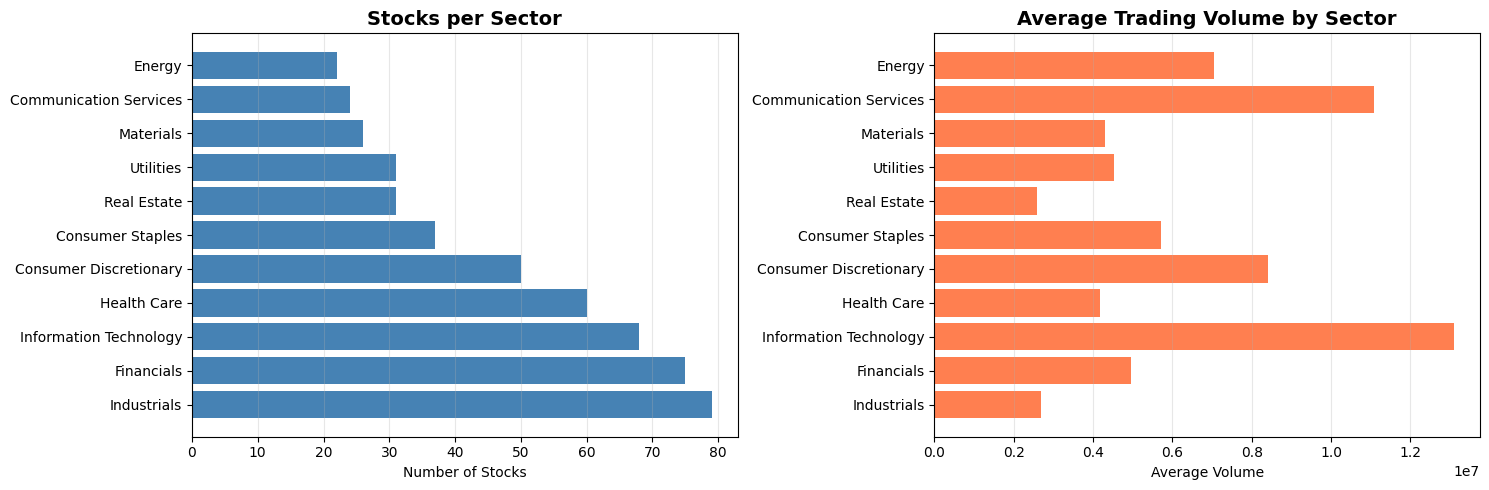

In [27]:
# Analyze average returns by sector
try:
    query_sector_performance = """
        SELECT 
            t.sector,
            COUNT(DISTINCT p.ticker) as num_stocks,
            AVG(p.[close]) as avg_price,
            AVG(CAST(p.volume AS FLOAT)) as avg_volume
        FROM market.daily_prices p
        JOIN market.sp500_tickers t ON p.ticker = t.ticker
        WHERE t.is_active = 1
        GROUP BY t.sector
        ORDER BY num_stocks DESC
    """
    
    sector_df = db.execute_query(query_sector_performance)
    
    print("📊 Sector Summary:")
    print(sector_df)
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Number of stocks per sector
    axes[0].barh(sector_df['sector'], sector_df['num_stocks'], color='steelblue')
    axes[0].set_xlabel('Number of Stocks')
    axes[0].set_title('Stocks per Sector', fontsize=14, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Average volume per sector
    axes[1].barh(sector_df['sector'], sector_df['avg_volume'], color='coral')
    axes[1].set_xlabel('Average Volume')
    axes[1].set_title('Average Trading Volume by Sector', fontsize=14, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"❌ Error analyzing sectors: {e}")

2025-10-02 20:12:43,565 - INFO - ✅ Query executed successfully, returned 250 rows


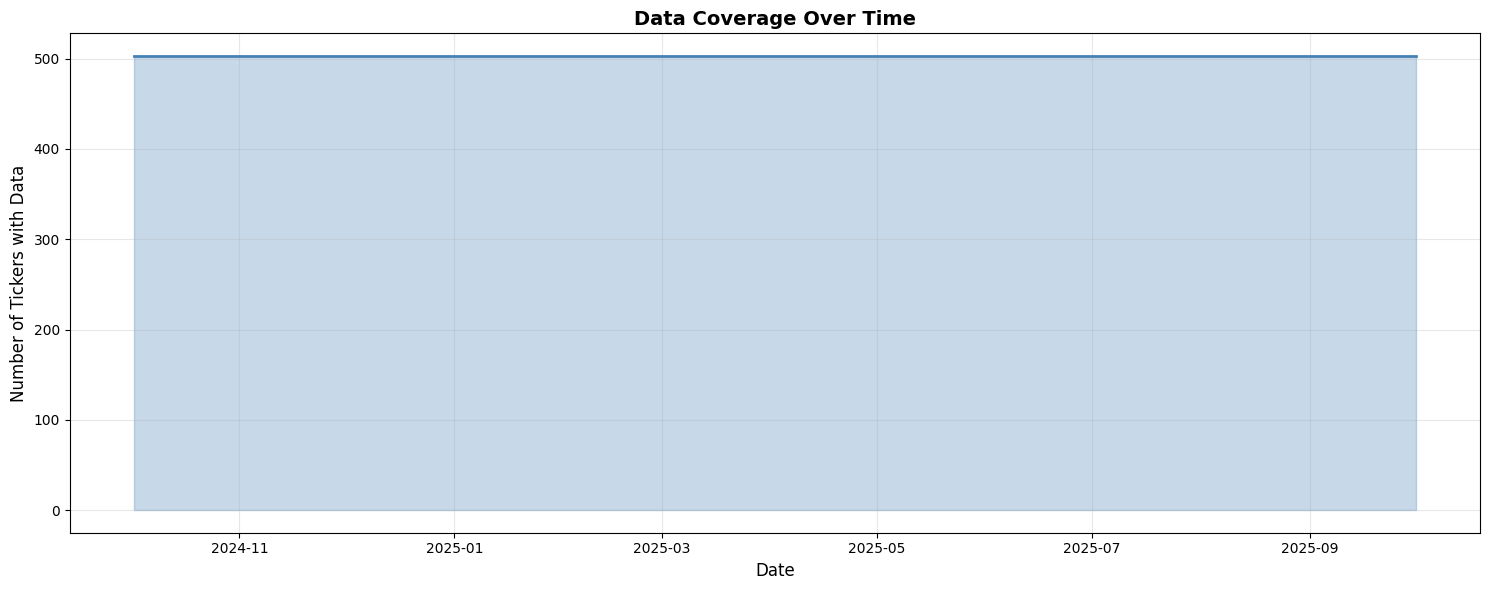

📊 Coverage Statistics:
   Average tickers per day: 503
   Min tickers per day: 503
   Max tickers per day: 503


In [29]:
# Create data coverage heatmap
try:
    # Get daily record counts
    query_coverage = """
        SELECT 
            date,
            COUNT(DISTINCT ticker) as num_tickers
        FROM market.daily_prices
        GROUP BY date
        ORDER BY date
    """
    
    coverage_df = db.execute_query(query_coverage)
    
    if not coverage_df.empty:
        # Convert to datetime
        coverage_df['date'] = pd.to_datetime(coverage_df['date'])
        coverage_df['week'] = coverage_df['date'].dt.isocalendar().week
        coverage_df['year'] = coverage_df['date'].dt.year
        coverage_df['day_of_week'] = coverage_df['date'].dt.dayofweek
        
        # Create pivot for recent data (last 3 months)
        recent_df = coverage_df[coverage_df['date'] >= coverage_df['date'].max() - pd.Timedelta(days=90)]
        
        plt.figure(figsize=(15, 6))
        plt.plot(coverage_df['date'], coverage_df['num_tickers'], linewidth=2, color='steelblue')
        plt.fill_between(coverage_df['date'], coverage_df['num_tickers'], alpha=0.3, color='steelblue')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Number of Tickers with Data', fontsize=12)
        plt.title('Data Coverage Over Time', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print(f"📊 Coverage Statistics:")
        print(f"   Average tickers per day: {coverage_df['num_tickers'].mean():.0f}")
        print(f"   Min tickers per day: {coverage_df['num_tickers'].min()}")
        print(f"   Max tickers per day: {coverage_df['num_tickers'].max()}")
    
except Exception as e:
    print(f"❌ Error creating coverage chart: {e}")

---

## 📝 Section 5: Summary & Next Steps

### Summary of Data Collection

In [30]:
# Generate final summary report
print("=" * 70)
print(" " * 20 + "📊 DATA COLLECTION SUMMARY")
print("=" * 70)

try:
    # Get comprehensive statistics
    stats = {}
    
    # Tickers
    result = db.execute_query("SELECT COUNT(*) as count FROM market.sp500_tickers")
    stats['total_tickers'] = result['count'].iloc[0]
    
    # Price records
    result = db.execute_query("SELECT COUNT(*) as count FROM market.daily_prices")
    stats['total_records'] = result['count'].iloc[0]
    
    # Distinct tickers with data
    result = db.execute_query("SELECT COUNT(DISTINCT ticker) as count FROM market.daily_prices")
    stats['tickers_with_data'] = result['count'].iloc[0]
    
    # Date range
    result = db.execute_query("SELECT MIN(date) as min_date, MAX(date) as max_date FROM market.daily_prices")
    stats['earliest_date'] = result['min_date'].iloc[0]
    stats['latest_date'] = result['max_date'].iloc[0]
    
    # Average records per ticker
    result = db.execute_query("""
        SELECT AVG(CAST(record_count AS FLOAT)) as avg_records
        FROM (
            SELECT ticker, COUNT(*) as record_count
            FROM market.daily_prices
            GROUP BY ticker
        ) as counts
    """)
    stats['avg_records_per_ticker'] = result['avg_records'].iloc[0]
    
    # Print summary
    print(f"\n📋 COLLECTION RESULTS:")
    print(f"   ✓ Total S&P 500 tickers: {stats['total_tickers']}")
    print(f"   ✓ Tickers with data: {stats['tickers_with_data']}")
    print(f"   ✓ Data completeness: {stats['tickers_with_data']/stats['total_tickers']*100:.1f}%")
    print(f"\n📊 PRICE DATA:")
    print(f"   ✓ Total records: {stats['total_records']:,}")
    print(f"   ✓ Date range: {stats['earliest_date']} to {stats['latest_date']}")
    print(f"   ✓ Avg records per ticker: {stats['avg_records_per_ticker']:.0f}")
    
    # Calculate data quality score
    quality_score = (stats['tickers_with_data'] / stats['total_tickers']) * 100
    
    print(f"\n⭐ DATA QUALITY SCORE: {quality_score:.1f}/100")
    
    if quality_score >= 95:
        print("   🎉 Excellent! Ready for analysis.")
    elif quality_score >= 85:
        print("   ✅ Good! Minor gaps may exist.")
    elif quality_score >= 70:
        print("   ⚠️  Fair. Consider re-running failed tickers.")
    else:
        print("   ❌ Poor. Many tickers failed. Check errors.")
    
    print("\n📅 NEXT STEPS:")
    print("   1. Review failed tickers (if any)")
    print("   2. Proceed to 02_stock_screening.ipynb")
    print("   3. Set up automated daily updates")
    
    print("=" * 70)
    
except Exception as e:
    print(f"❌ Error generating summary: {e}")

2025-10-02 20:12:54,822 - INFO - ✅ Query executed successfully, returned 1 rows
2025-10-02 20:12:54,844 - INFO - ✅ Query executed successfully, returned 1 rows
2025-10-02 20:12:54,865 - INFO - ✅ Query executed successfully, returned 1 rows
2025-10-02 20:12:54,872 - INFO - ✅ Query executed successfully, returned 1 rows
2025-10-02 20:12:54,895 - INFO - ✅ Query executed successfully, returned 1 rows


                    📊 DATA COLLECTION SUMMARY

📋 COLLECTION RESULTS:
   ✓ Total S&P 500 tickers: 503
   ✓ Tickers with data: 503
   ✓ Data completeness: 100.0%

📊 PRICE DATA:
   ✓ Total records: 125,750
   ✓ Date range: 2024-10-02 to 2025-10-01
   ✓ Avg records per ticker: 250

⭐ DATA QUALITY SCORE: 100.0/100
   🎉 Excellent! Ready for analysis.

📅 NEXT STEPS:
   1. Review failed tickers (if any)
   2. Proceed to 02_stock_screening.ipynb
   3. Set up automated daily updates


In [31]:
# Optional: Export summary statistics to CSV
try:
    # Export ticker list
    ticker_list = db.execute_query("SELECT * FROM market.sp500_tickers WHERE is_active = 1")
    ticker_list.to_csv(project_root / 'data' / 'sp500_tickers.csv', index=False)
    print(f"✅ Exported ticker list to: data/sp500_tickers.csv")
    
    # Export records per ticker
    records_per_ticker = db.execute_query("""
        SELECT 
            ticker,
            COUNT(*) as record_count,
            MIN(date) as earliest_date,
            MAX(date) as latest_date
        FROM market.daily_prices
        GROUP BY ticker
        ORDER BY ticker
    """)
    records_per_ticker.to_csv(project_root / 'data' / 'data_coverage_summary.csv', index=False)
    print(f"✅ Exported coverage summary to: data/data_coverage_summary.csv")
    
except Exception as e:
    print(f"⚠️  Error exporting summaries: {e}")

2025-10-02 20:13:02,544 - INFO - ✅ Query executed successfully, returned 503 rows
2025-10-02 20:13:02,650 - INFO - ✅ Query executed successfully, returned 503 rows


✅ Exported ticker list to: data/sp500_tickers.csv
✅ Exported coverage summary to: data/data_coverage_summary.csv


In [32]:
# Close database connection
db.close()
print("✅ Database connection closed")
print("🎉 Data collection complete!")

2025-10-02 20:13:10,144 - INFO - 🔌 Database connection closed


✅ Database connection closed
🎉 Data collection complete!
